In [9]:
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [10]:
# 1.3 Read in the data set
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
training_data = read_idx('./MNIST/train-images.idx3-ubyte')
training_labels = read_idx('./MNIST/train-labels.idx1-ubyte')
validation_data = read_idx('./MNIST/t10k-images.idx3-ubyte')
validation_labels = read_idx('./MNIST/t10k-labels.idx1-ubyte')

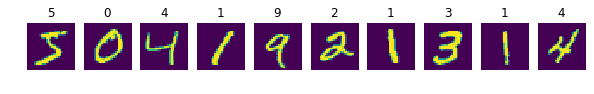

In [11]:
# 1.4 Investigate the data.
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    ax[i].imshow(training_data[i])
    ax[i].axis('off')
    ax[i].set_title(training_labels[i])

## The Dataset
At this point our dataset is stored in numpy arrays:

In [12]:
print("Training Input Properties: Type: {}, Shape: {}, Datatype: {}".format(type(training_data), training_data.shape, training_data.dtype))
print("Training Labels Properties: Type: {}, Shape: {}, Datatype: {}".format(type(training_labels), training_labels.shape, training_labels.dtype))
print("Validation Input Properties: Type: {}, Shape: {}, Datatype: {}".format(type(validation_data), validation_data.shape, validation_data.dtype))
print("Validation Labels Properties: Type: {}, Shape: {}, Datatype: {}".format(type(validation_labels), validation_labels.shape, validation_labels.dtype))

Training Input Properties: Type: <class 'numpy.ndarray'>, Shape: (60000, 28, 28), Datatype: uint8
Training Labels Properties: Type: <class 'numpy.ndarray'>, Shape: (60000,), Datatype: uint8
Validation Input Properties: Type: <class 'numpy.ndarray'>, Shape: (10000, 28, 28), Datatype: uint8
Validation Labels Properties: Type: <class 'numpy.ndarray'>, Shape: (10000,), Datatype: uint8


TensorFlow has a class called "tf.data.Dataset" (https://www.tensorflow.org/api_docs/python/tf/data/Dataset). This class allows you to apply different functions to the dataset and to easily read out properties of the dataset.  
We use a function that allows us to build such dataset objects by feeding in numpy arrays called "from_tensor_slices" and takes as an argument a tuple with the input data and the according labels.

In [13]:
tf.reset_default_graph()
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

Let's see how we can now read out the properties of our dataset objects.

In [14]:
print(training_dataset.output_shapes)
print(training_dataset.output_types)
print(validation_dataset.output_shapes)
print(validation_dataset.output_types)

(TensorShape([Dimension(28), Dimension(28)]), TensorShape([]))
(tf.uint8, tf.uint8)
(TensorShape([Dimension(28), Dimension(28)]), TensorShape([]))
(tf.uint8, tf.uint8)


Obviously the properties of the training- and the validation dataset are the same. The first component in each tuple refers to the input data and the second one to the labels.  
We see that our input still has the image format of 28x28, while the labels have no shapes, as they are just a single number (0-9).  
The datatypes are the same as before.

Additionally to reading out these properties there is a bunch of functions that we can apply to the dataset.  
For example we would like to shuffle the dataset in each iteration, such that we have more variance in the training process.  
This can easily be done by the function "shuffle". We need to give a parameter defining how many of the elements should be shuffled. This is only interesting for very large datasets. We can just set it to the total number of samples in out dataset.

In [15]:
training_dataset = training_dataset.shuffle(buffer_size = 60000)

Later during the training process we don't want to feed single samples for our dataset, but mini-batches. The dataset object has a function that does this for us. The function is called "batch" and what it does is basically the following:  
When using mini-batch gradient descent what you do is you don't feed single samples through the network but a lot of samples at once. By applying the "batch" function to the dataset it gets restructured such that it does not consist out of single samples anymore, but it now consists out of mini-batches.

In [16]:
training_batch_size = 128
validation_batch_size = 10000
training_dataset = training_dataset.batch(training_batch_size, drop_remainder=False)
validation_dataset = validation_dataset.batch(validation_batch_size, drop_remainder=False)

To understand better how the dataset object changed let's again print the properties.

In [17]:
print(training_dataset.output_shapes)
print(training_dataset.output_types)
print(validation_dataset.output_shapes)
print(validation_dataset.output_types)

(TensorShape([Dimension(None), Dimension(28), Dimension(28)]), TensorShape([Dimension(None)]))
(tf.uint8, tf.uint8)
(TensorShape([Dimension(None), Dimension(28), Dimension(28)]), TensorShape([Dimension(None)]))
(tf.uint8, tf.uint8)


What changed is that now each shape has a new first dimension. This dimension is the referring to batchsize. For example: the input of the training dataset are now longer only images of shape 28x28 but mini-batches of images of shape batchsizex28x28. The reason that this dimension has "length" None instead of 128 is because there might be batch in the end that has less than 128 elements. We allowed this by setting the parameter "drop_remainder=False". If you want to try it you can set it to "True" and you will see that the input of the training dataset will now have the shape 128x28x28.

The dataset object has a lot of very useful functions but it is missing one very important thing. There is no function to grab elements out of the dataset. For this there is the iterator class, called "tf.data.Iterator" (https://www.tensorflow.org/api_docs/python/tf/data/Iterator).  
Iterators are objects that will be loaded with a dataset and then allows us to iterate over the dataset. Meaning we can grab mini-batch for mini-batch out of the dataset until there is no mini-batch left.

The interesting thing here is that the iterator is not directly dataset dependent. The only thing it depends on is the "structure" of the dataset, i.e. the datatypes and shapes of the input and the lablels. It is so to say an empty truck waiting for a load that should have specific dimensions.

In [18]:
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)

The iterator object has a method called "make_initializer" which gets a dataset as an input. This method loads a dataset into the iterator object.  
As we observed earlier these are the same for the training and the validation dataset, so we can use the same iterator object for both datasets.  
Below we do not load the data into the iterator. We only give the operation of loading the training- or the validation data into the iterator a shorter variable name.

In [19]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

Now we prepared everything to build the model of the neural network that we would like to use to process our data.  
Here it is important to keep in mind that we are not doing any calculations here but we are only building the so called data flow graph (DFG). This data flow graph will be called and run later when we run the TensorFlow Sessions.  

The first thing we need to define how our network processes our input mini-batches is a mini-batch.  
We can easily get this by using a method for the iterator object called "get_next".  

In [20]:
next_batch = iterator.get_next()

This batch is a tuple with the input data in it's first component and the label in it's second component

In [21]:
print(next_batch)
input_data  = next_batch[0]
labels = next_batch[1]

(<tf.Tensor 'IteratorGetNext:0' shape=(?, 28, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=uint8>)


Remember the following: Later when we run a session to evaluate a node (e.g. the loss) the data flow graph is used to trace back which nodes have to be evaluated first before the node of interest (e.g. the loss) can be evaluated. This tracing back leads ultimately to the "next_batch" node that we defined three cells above. By evaluating this node a new batch from the dataset will be grabbed and from there all nodes below can be evaluated.

We will use the following model:

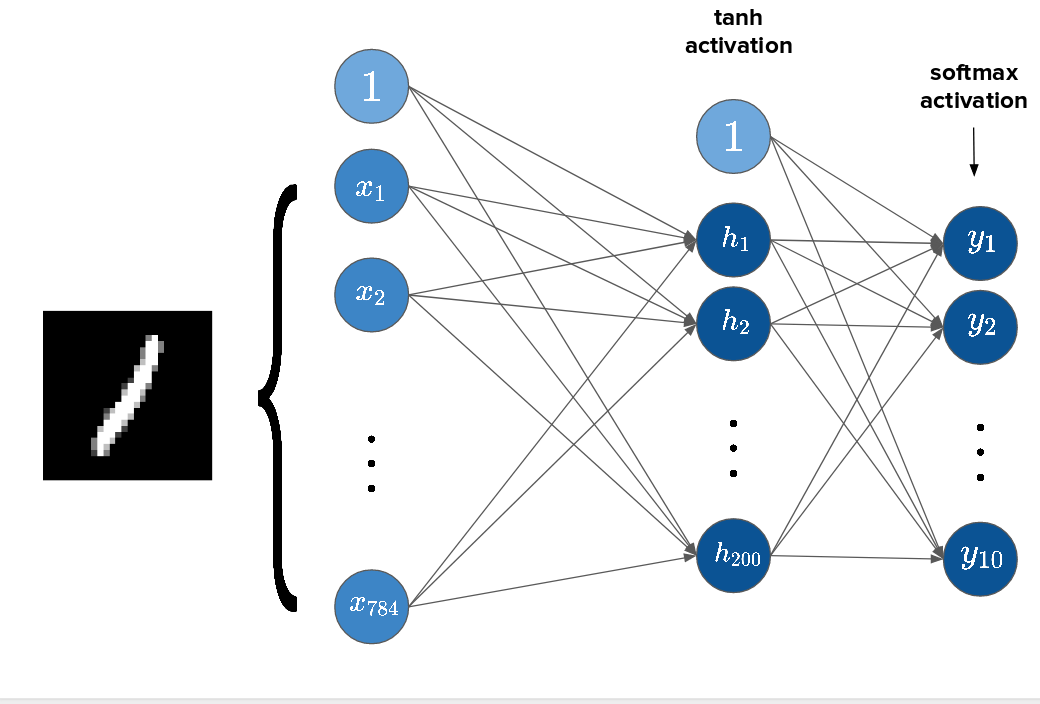

Let's first have a look now at our input data and at our labels to understand what we are dealing now with.

In [22]:
print(input_data)
print(labels)

Tensor("IteratorGetNext:0", shape=(?, 28, 28), dtype=uint8)
Tensor("IteratorGetNext:1", shape=(?,), dtype=uint8)


The question mark in the shape is referring to the batch size. Because we will use a fully-connected feed forward neural network we need to flatten the images to a tensor of only two ranks with shape (batch size, 28*28=784).  
Additionally we need to cast the input to float values, because otherwise the multiplication with weights later won't work.  

For reshaping we can use the TensorFlow function tf.reshape. As a parameter we need to specify the new shape that we would like to have namely (batch size, 784). The problem is that the batch size is at this point unknown (training dataset and validation dataset have different batch sizes + the last batches might be smaller). To fix this problem there is a "code". If we would like to keep the batch size as it is we can tell the function to reshape to (-1,784). The "-1" is the "code" and means that we would like TensorFlow to infer itself how large the first dimension has to be such that the original tensor fits into the new shape.  
Check the API for some examples: https://www.tensorflow.org/api_docs/python/tf/reshape

In [23]:
input_data = tf.reshape(input_data,shape=[-1,784])
input_data = tf.cast(input_data, tf.float32)

The labels are later needed to be of type tf.int64. So we need to cast them to.  
Additionally we need them in one-hot format to compare them to the output of the neural network. For this we can use the function tf.one_hot. We have to specify how large the one-hot vectors should be (10 because we have 10 classes) in the parameter "depth". 

In [24]:
labels = tf.cast(labels, tf.int64)
labels_onehot = tf.one_hot(labels, depth=10)

Now that the input and the labels are prepared we can implement the forward step.  
For this we need two variables namely the weights and the biases. We define them as tf.Variables which means that they can be changed later during training.  
As our input now has the shape (batchsize, 784) we need weights of the shape (784, 200) to obtain an output of (batchsize, 200) after the matrix multiplication in the hidden layer. The biases will be added after the matrix multiplication so we need 200 biases.

In [25]:
weights_1 = tf.Variable(tf.random_normal([784, 200], stddev = 0.000002))
biases_1 = tf.Variable(tf.zeros([200]))

Now we can define the forwardstep. First we multiply our input data with the weights.

In [26]:
weighted_sum_1 = tf.matmul(input_data, weights_1)
print(weighted_sum_1)
print(biases_1)

Tensor("MatMul:0", shape=(?, 200), dtype=float32)
<tf.Variable 'Variable_1:0' shape=(200,) dtype=float32_ref>


As a next step we add the bias. The bias only has shape (200), while the weighted sum has shape (batchsize, 200).  
Still we can just add it and TensorFlow itself infers that it should be added to each collumn of the (batchsize, 200) tensor.  
As a next step we apply the tanh activation function. (https://www.tensorflow.org/api_docs/python/tf/math/tanh)



In [27]:
drive = weighted_sum_1 + biases_1
hidden_layer = tf.nn.tanh(drive)

Now we have the activations of the hidden layer and we do the second forward step. The most part is the same as above:

In [28]:
weights_2 = tf.Variable(tf.random_normal([200, 10], stddev = 0.000002))
biases_2 = tf.Variable(tf.zeros([10]))
weighted_sum_2 = tf.matmul(hidden_layer, weights_2)
logits = weighted_sum_2 + biases_2

The logits are now the drive of our last output layer. The last thing to do is to apply the softmax activation function.


The softmax function per default calculates the softmax along the last dimension (https://www.tensorflow.org/api_docs/python/tf/nn/softmax)

In [29]:
output = tf.nn.softmax(logits)

Now that we have the output we can comput the loss. For this we first comput the cross entropy of the outputs for all samples of this batch with the labels in one-hot version.   

As you can infer from the name of the function the function itself applies the softmax function we pass the logits as input argument.
https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2

In [30]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels_onehot, logits=logits )
print(cross_entropy)

Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(?,), dtype=float32)


We see above that we have a tensor of shape (batchsize) with the cross entropy value for each single sample in our mini-batch. To obtain one value we need to take the mean of that

In [31]:
loss = tf.reduce_mean(cross_entropy)

To calculate the accuracy we need to interpret the outputs of our neural network as a guess for one of the ten classes. To do this we look for the highest value in the softmax output of the network. Because we want to get one guess for each sample in our mini-batch we have to specify that we would like to look for the maximum only along the second axis.

In [32]:
guesses = tf.argmax(output,1)
print(guesses)

Tensor("ArgMax:0", shape=(?,), dtype=int64)


We can now easily compare these guesses with the original labels (not the onehot labels). For this we can use tf.equal which will return an arrar of True and False values.  
By casting them to 1s and 0s and calculating the mean we can calculate how many percent of the guesses were true. This is the accuracy.

In [33]:
accuracy = tf.equal(tf.argmax(output, 1), labels)
accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

Now we are basically done with our model.  
The last step is to define how we would like to optimize our variables to improve our model.   
For this TensorFlow has different optimizer objects that can be used for exactly this purpose:https://www.tensorflow.org/api_docs/python/tf/train

In [34]:
learning_rate = 1e-5
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

The optimizer has different methods (https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer). The most interesting ones for us are "calculate_gradients", "apply_gradients", "minimize". All of them need an objective to minimize (in our case the loss).  
If we would define a node calculate_gradients(loss) and later evaluate this node this node would return the gradient for all trainable variables (weights and biases).  
If we define a second node apply_gradients(calculate_gradients(loss)) and evaluate it this node does not return anything but in the background update all the trainable variables with the gradients calculated before.  
And this is exactly what the method minimize(loss) does. In one node it calculates the gradients and applies them. So we only need to define one node.

In [35]:
training_step = optimizer.minimize(loss)

And now we are really done and we can get into to the phase of actually calculating stuff.  
To evaluate anything we need to start a TensorFlow session. We then use this session to evaluate certain nodes by using the session method "run" (https://www.tensorflow.org/api_docs/python/tf/Session#run).  

For example in the beginning we need to "run" all the nodes that we defined as variables once such that there actually some values in it. For this TensorFlow has a function called "tf.global_variables_initializer()".  

When we have done this we can go into our loop of epochs. We define how many epochs we want to do. One epoch always consists of training on all the mini-batches of our training dataset once and after that validating the made progress once on the validation dataset.  

First we do the training: Remember that we had the iterator which was like an empty truck. Now we would like to load our training dataset into the iterator. This is done by runninng the operation that defined for this purpose before namely "training_init_op".  

Once we did this we can actually start the training. And this is now where all the magic happens: We only need to evaluate the node "training_step". If we look above this node is instructed to minimize the loss (calculating and applying the gradients to minimize the loss). To do so first we need to evaluate the loss. But for this we need to calculate the outputs by doing a forward step. And for this we need the input. And this is now where the "iterator.get_next()" method is called to obtain the next batch from our dataset.  

From there TensorFlow can now calculate all the way forward up to the loss, calculate and apply the gradients. All of this in this one single line.  

We can do this as long as there a still mini-batches in our dataset (once a batch is used it won't be used again). So if we are done we will get an "tf.errors.OutOfRangeError" telling us that we are done with the training dataset.

The last step then is the validation. The iterator is empty so we can reload it. And now we load the validation dataset into the iterator. The validation dataset only contains one single batch of all 10000 validation samples. So we don't have to use the while True loop from before. In the validation step we only want to get the loss and accuracy value so we evaluate these two nodes. Now the same happens as in the training. TensorFlow traces backwards which nodes have to be evaluated in order to evaluate the nodes of interest. This goes back until the "iterator.get_next()" method is called and grabs the single large batch out of the dataset. 


In [36]:
epochs = 100
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    
    for _ in range(epochs):
        
        
        
        sess.run(training_init_op)
      
        while True:
            try:
                _ = sess.run((training_step))
            except tf.errors.OutOfRangeError:
                break
             
            
    
        sess.run(validation_init_op)
        
        loss_value, accuracy_value = sess.run((loss, accuracy))
        print(loss_value, accuracy_value)
                    
        


2.302583 0.1135
2.30258 0.1135
2.3025737 0.1135
2.3025558 0.1138
2.3024988 0.2181
2.3023067 0.2758
2.3016772 0.287
2.2997954 0.3121
2.294928 0.3323
2.284603 0.3392
2.2670915 0.3463
2.242541 0.3578
2.212435 0.3691
2.1785722 0.3839
2.1424987 0.4026
2.1053834 0.4206
2.0680356 0.4345
2.0309665 0.4562
1.9945313 0.4746
1.9589522 0.4918
1.9242902 0.5078
1.8906274 0.5224
1.8580441 0.5328
1.8264285 0.5471
1.7958746 0.5585
1.7662687 0.568
1.7376764 0.5761
1.7100047 0.5848
1.6831722 0.5907
1.6571728 0.5977
1.632049 0.6032
1.6076736 0.6095
1.5840348 0.614
1.5610068 0.6173
1.5387573 0.6234
1.5170456 0.6262
1.4960481 0.6313
1.4756318 0.6352
1.4557384 0.6422
1.436417 0.6494
1.4176233 0.6572
1.3992442 0.6658
1.3814155 0.6732
1.3639766 0.6831
1.3470991 0.6915
1.3305336 0.6994
1.314344 0.708
1.2985151 0.7168
1.2831196 0.7256
1.2680447 0.7312
1.253276 0.7371
1.2389448 0.7443
1.2247412 0.7524
1.2108843 0.7586
1.1973621 0.765
1.1840951 0.7705
1.1710463 0.7769
1.1582445 0.7819
1.14579 0.7873
1.1334592 0.793